# Camera Calibration Notebook

## 1. Introduction and Setup

### Introduction to Camera Calibration

Camera calibration is the process of estimating the parameters of a camera's imaging system. These parameters include:

1. Intrinsic parameters: focal length, optical center, and lens distortion coefficients.
2. Extrinsic parameters: rotation and translation of the camera with respect to a world coordinate system.

Calibration is crucial for:
- Correcting lens distortion
- Measuring objects in world units
- 3D reconstruction
- Augmented reality applications

In this notebook, we'll perform camera calibration using a chessboard pattern and visualize the results.

### Setup: Importing necessary libraries

Let's start by importing the required libraries:

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

%matplotlib inline 


## 2. Image Collection

In this section, we'll load our calibration images and display a sample image to ensure everything is set up correctly.

### Load calibration images

We'll use glob to find all the calibration images in a specified directory.

### Display a sample image

We'll display the first image from our collection to visually verify our data.

Found 8 calibration images.


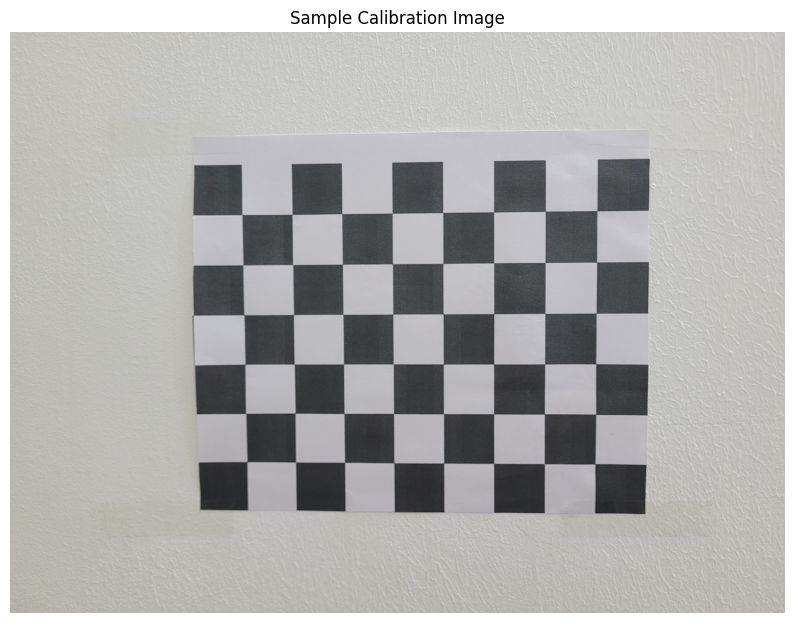

Image dimensions: 4032 x 3024 pixels


In [4]:
# Specify the path to your calibration images
images_path = 'calib_imgs/*.jpg'  # Adjust this path as needed

# Get a list of all calibration image file paths
images = sorted(glob.glob(images_path))

print(f"Found {len(images)} calibration images.")

# Read and display the first image
if images:
    sample_image = cv2.imread(images[0])
    sample_image_rgb = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 8))
    plt.imshow(sample_image_rgb)
    plt.title('Sample Calibration Image')
    plt.axis('off')
    plt.show()
else:
    print("No calibration images found. Please check the image path.")

# Print image dimensions
if 'sample_image' in locals():
    print(f"Image dimensions: {sample_image.shape[1]} x {sample_image.shape[0]} pixels")

## 3. Chessboard Detection

In this section, we'll detect the chessboard corners in all calibration images. This is a crucial step for camera calibration as it provides the necessary point correspondences between the 2D image points and the 3D world points.

### Define the chessboard size

We need to specify the number of inner corners in the chessboard pattern.

### Prepare object points

We'll create a set of 3D points representing the chessboard corners in the world coordinate system.

### Detect chessboard corners

We'll iterate through all images, detect the chessboard corners, and store the results.

### Visualize detected corners

We'll display a sample image with the detected corners overlaid to verify the detection process.

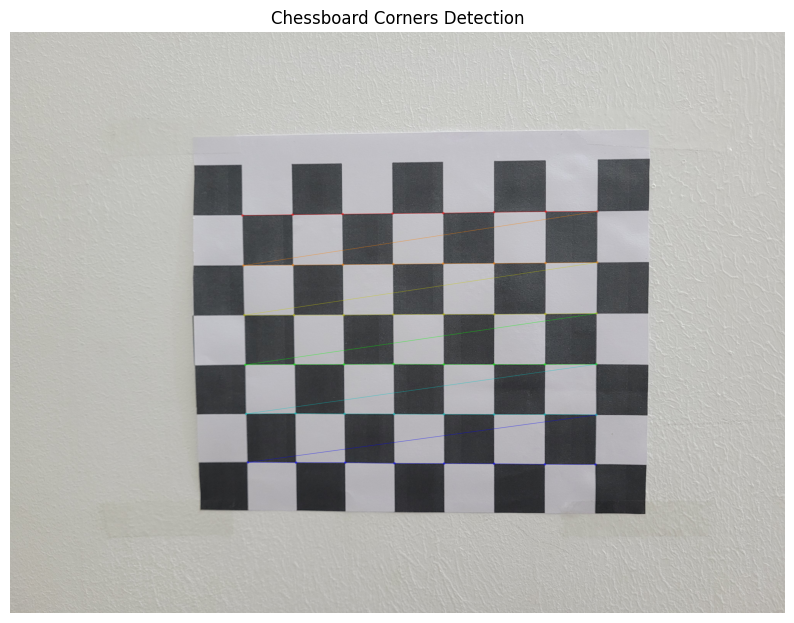

Successfully detected corners in 8 out of 8 images.


In [6]:
# Define the chessboard size (number of inner corners)
chessboard_size = (8, 6)  # Adjust this based on your chessboard pattern

# Prepare object points
square_size_mm = 0.025
objp = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2) * square_size_mm
# Arrays to store object points and image points from all images
objpoints = []  # 3D points in real world space
imgpoints = []  # 2D points in image plane

# Iterate through all images
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    # If found, add object points and image points
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners on a sample image
        if fname == images[0]:  # Only for the first image
            img_corners = cv2.drawChessboardCorners(img.copy(), chessboard_size, corners, ret)
            plt.figure(figsize=(10, 8))
            plt.imshow(cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB))
            plt.title('Chessboard Corners Detection')
            plt.axis('off')
            plt.show()

print(f"Successfully detected corners in {len(objpoints)} out of {len(images)} images.")

## 4. Camera Calibration

In this section, we'll perform the camera calibration using the detected chessboard corners. We'll then extract the camera matrix and distortion coefficients.

### Perform camera calibration

We'll use OpenCV's `calibrateCamera` function to compute the camera calibration parameters.

### Extract calibration results

We'll extract and display the camera matrix and distortion coefficients.

### Interpret the results

We'll briefly explain what each parameter means and its significance in camera calibration.

Camera calibrated: 1.438506811968531

Camera matrix:
[[3.05101150e+03 0.00000000e+00 2.03704840e+03]
 [0.00000000e+00 3.04732959e+03 1.48500930e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients:
[[ 6.64243281e-02 -5.40126143e-01 -2.13798283e-04  1.28409866e-03
   1.49185212e+00]]

Interpretation of the camera matrix:
Focal length: (3051.01, 3047.33)
Principal point: (2037.05, 1485.01)

Interpretation of distortion coefficients:
Radial distortion: (k1: 0.0664, k2: -0.5401, k3: 1.4919)
Tangential distortion: (p1: -0.0002, p2: 0.0013)


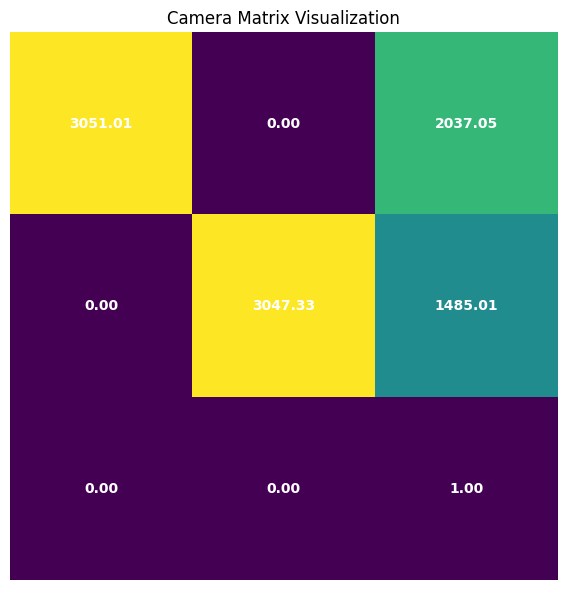

In [7]:
# Perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# Print calibration results
print("Camera calibrated:", ret)
print("\nCamera matrix:")
print(mtx)
print("\nDistortion coefficients:")
print(dist)

# Interpret the results
print("\nInterpretation of the camera matrix:")
print(f"Focal length: ({mtx[0,0]:.2f}, {mtx[1,1]:.2f})")
print(f"Principal point: ({mtx[0,2]:.2f}, {mtx[1,2]:.2f})")

print("\nInterpretation of distortion coefficients:")
print(f"Radial distortion: (k1: {dist[0,0]:.4f}, k2: {dist[0,1]:.4f}, k3: {dist[0,4]:.4f})")
print(f"Tangential distortion: (p1: {dist[0,2]:.4f}, p2: {dist[0,3]:.4f})")

# Visualize the camera matrix with numbers, without color bar and colors
plt.figure(figsize=(6, 6))
plt.imshow(mtx, aspect='equal')
plt.title('Camera Matrix Visualization')

# Add text annotations
for i in range(mtx.shape[0]):
    for j in range(mtx.shape[1]):
        text = plt.text(j, i, f'{mtx[i, j]:.2f}',
                        ha="center", va="center", color="white",
                        fontweight='bold')

plt.axis('off')  # Turn off axis
plt.tight_layout()
plt.show()

## 5. Image Undistortion

In this section, we'll use the calibration results to undistort images and visualize the effect of lens correction.

### Apply undistortion to a sample image

We'll use OpenCV's `undistort` function to correct the lens distortion in our sample image.

### Visualize the undistortion effect

We'll display the original and undistorted images side by side for comparison.

### Analyze the undistortion results

We'll discuss the visible changes in the image and their significance.

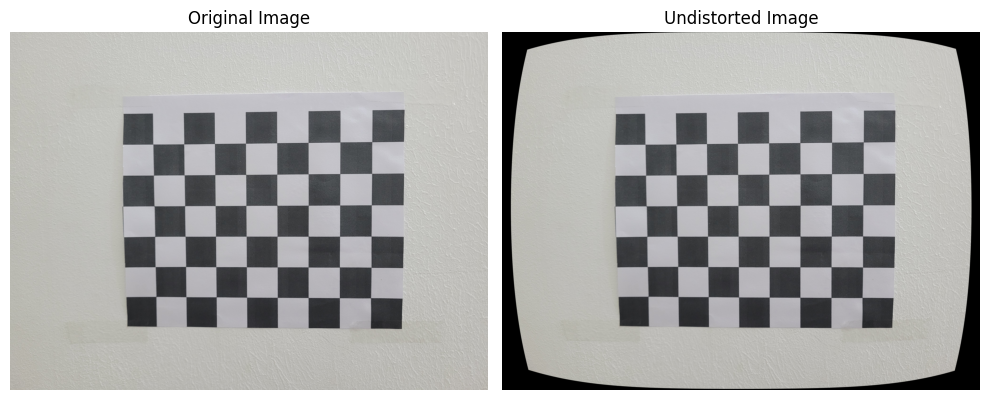

Undistortion Analysis:
1. Observe the straightening of lines, especially near the edges of the image.
2. Notice any changes in the image proportions or perspective.
3. Look for reductions in barrel or pincushion distortion effects.

Note: The severity of the changes will depend on the level of distortion in the original image.


In [8]:
# Load a sample image for undistortion
sample_img = cv2.imread(images[0])
h, w = sample_img.shape[:2]

# Undistort the image
dst = cv2.undistort(sample_img, mtx, dist, None, mtx)


# Display the original and undistorted images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.imshow(cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.set_title('Undistorted Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

# Analyze the results
print("Undistortion Analysis:")
print("1. Observe the straightening of lines, especially near the edges of the image.")
print("2. Notice any changes in the image proportions or perspective.")
print("3. Look for reductions in barrel or pincushion distortion effects.")
print("\nNote: The severity of the changes will depend on the level of distortion in the original image.")


## 6. Calibration Quality Assessment

In this section, we'll assess the quality of our camera calibration by calculating and visualizing the reprojection error.

### Calculate Reprojection Error

We'll compute the reprojection error for each calibration image and calculate the mean error.

### Visualize Reprojection Error

We'll create a histogram of reprojection errors to visualize their distribution.

### Interpret the Results

We'll discuss what the reprojection error means and what constitutes a good calibration result.

Mean reprojection error: 0.19645 pixels


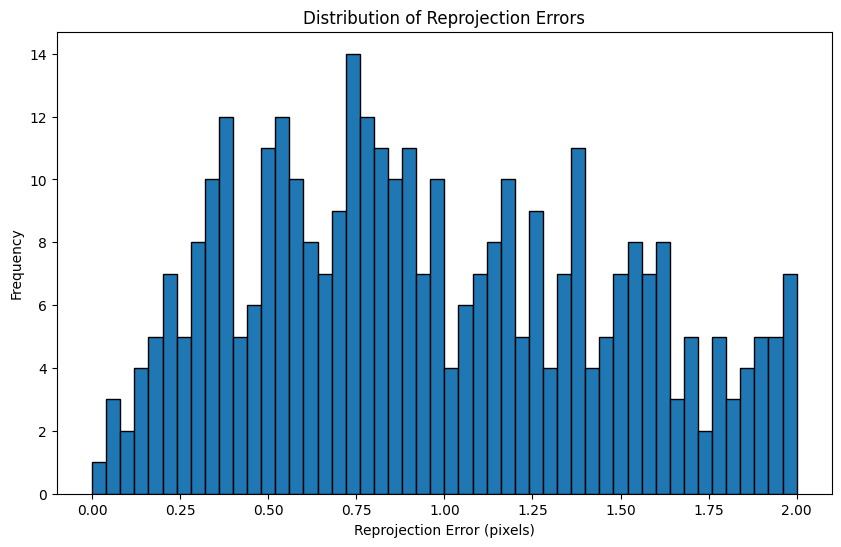

Minimum reprojection error: 0.00746 pixels
Maximum reprojection error: 7.07957 pixels
Median reprojection error: 0.97486 pixels

Interpretation of Results:
1. A mean reprojection error below 1 pixel is generally considered good.
2. The distribution of errors should be roughly Gaussian and centered near zero.
3. Large outliers in the error distribution may indicate issues with specific calibration images.
4. If the error is consistently high, consider recapturing calibration images or adjusting the calibration process.


In [9]:
# Calculate reprojection error
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

mean_error /= len(objpoints)

print(f"Mean reprojection error: {mean_error:.5f} pixels")

# Calculate reprojection error for each point in each image
total_error = []
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = np.sum(np.abs(imgpoints[i] - imgpoints2)**2, axis=2).reshape(-1)
    total_error.extend(error)

# Visualize reprojection error distribution
plt.figure(figsize=(10, 6))
plt.hist(np.sqrt(total_error), bins=50, range=(0, 2), edgecolor='black')
plt.title('Distribution of Reprojection Errors')
plt.xlabel('Reprojection Error (pixels)')
plt.ylabel('Frequency')
plt.show()

# Calculate and print some statistics
error_array = np.array(total_error)
print(f"Minimum reprojection error: {np.min(np.sqrt(error_array)):.5f} pixels")
print(f"Maximum reprojection error: {np.max(np.sqrt(error_array)):.5f} pixels")
print(f"Median reprojection error: {np.median(np.sqrt(error_array)):.5f} pixels")

# Interpret the results
print("\nInterpretation of Results:")
print("1. A mean reprojection error below 1 pixel is generally considered good.")
print("2. The distribution of errors should be roughly Gaussian and centered near zero.")
print("3. Large outliers in the error distribution may indicate issues with specific calibration images.")
print("4. If the error is consistently high, consider recapturing calibration images or adjusting the calibration process.")

## 7. Visualizing Camera Poses

In this section, we'll visualize the estimated camera poses for each calibration image. This visualization will help us understand the spatial relationship between the camera and the calibration pattern in 3D space.

### Prepare Camera Pose Data

We'll extract the rotation and translation vectors for each calibration image.

### Create 3D Visualization

We'll create a 3D plot showing the position and orientation of the camera for each calibration image relative to the chessboard.

### Interpret the Results

We'll discuss what the visualization tells us about the camera's movement during the calibration process.

In [10]:
%matplotlib qt 

def draw_camera(ax, R, t, scale=0.08):
    # Camera frame
    cam_points = np.array([
        [0, 0, 0],  # Camera center
        [1, 1, 2],  # Top-right corner
        [1, -1, 2], # Bottom-right corner
        [-1, -1, 2],# Bottom-left corner
        [-1, 1, 2]  # Top-left corner
    ]) * scale

    cam_points_world = (R @ cam_points.T + t.reshape(3, 1)).T

    # Plot camera frame
    # Base of the pyramid
    ax.plot(cam_points_world[[1,2,3,4,1], 0],
            cam_points_world[[1,2,3,4,1], 1],
            cam_points_world[[1,2,3,4,1], 2], 'r-')
    
    # Lines from camera center to corners
    for i in range(1, 5):
        ax.plot(cam_points_world[[0,i], 0],
                cam_points_world[[0,i], 1],
                cam_points_world[[0,i], 2], 'r-')

    # Plot camera center
    ax.scatter(cam_points_world[0, 0], cam_points_world[0, 1], cam_points_world[0, 2], color='r', s=50)

# Create 3D plot
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot chessboard plane
X, Y, Z = objp[:,0], objp[:,1], objp[:,2]
ax.scatter(X, Y, Z, alpha=0.5)

# Plot camera poses
for i, (R, t) in enumerate(zip(rvecs, tvecs)):
    R = cv2.Rodrigues(R)[0]
    R = np.linalg.inv(R)
    t = -t
    
    draw_camera(ax, R, t)
    ax.text(t[0][0], t[1][0], t[2][0], f'{i+1}', fontsize=8)

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Camera Poses Relative to Chessboard')

# Set equal aspect ratio
ax.set_box_aspect((1, 1, 1))

# Get the limits of all axes
x_lim = ax.get_xlim()
y_lim = ax.get_ylim()
z_lim = ax.get_zlim()

# Find the range
max_range = np.array([x_lim[1]-x_lim[0], y_lim[1]-y_lim[0], z_lim[1]-z_lim[0]]).max() / 2.0

# Find the center
mid_x = np.mean(x_lim)
mid_y = np.mean(y_lim)
mid_z = np.mean(z_lim)

# Set the limits for all axes
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_y - max_range, mid_y + max_range)
ax.set_zlim(mid_z - max_range, mid_z + max_range)

# Calculate and print camera position statistics
camera_positions = np.array([t.ravel() for t in tvecs])
mean_position = np.mean(camera_positions, axis=0)
std_position = np.std(camera_positions, axis=0)

print(f"Mean camera position: X={mean_position[0]:.2f}, Y={mean_position[1]:.2f}, Z={mean_position[2]:.2f}")
print(f"Standard deviation of camera positions: X={std_position[0]:.2f}, Y={std_position[1]:.2f}, Z={std_position[2]:.2f}")

plt.tight_layout()
plt.show()

# Interpretation of the results
print("\nInterpretation of Camera Pose Visualization:")
print("1. Each point represents a camera position for a calibration image.")
print("2. The chessboard plane is shown at Z=0.")
print("3. The spread of camera positions shows the variety of viewpoints used in calibration.")
print("4. Ideally, you want a good distribution of camera positions around the chessboard.")
print("5. If all points are clustered in one area, consider taking more diverse calibration images.")

Mean camera position: X=-0.08, Y=-0.05, Z=0.41
Standard deviation of camera positions: X=0.01, Y=0.01, Z=0.10

Interpretation of Camera Pose Visualization:
1. Each point represents a camera position for a calibration image.
2. The chessboard plane is shown at Z=0.
3. The spread of camera positions shows the variety of viewpoints used in calibration.
4. Ideally, you want a good distribution of camera positions around the chessboard.
5. If all points are clustered in one area, consider taking more diverse calibration images.


## 8. Saving and Calibration Results

In this section, we'll save our calibration results to a file and demonstrate how to load them back. This is crucial for reusing the calibration data in other projects or sessions.

### Save Calibration Results

We'll use NumPy's save function to store our calibration data in a compressed format.

```python
import numpy as np
import os

# Create a dictionary to hold all calibration data
calibration_data = {
    'camera_matrix': mtx,
    'dist_coeffs': dist,
    'rvecs': rvecs,
    'tvecs': tvecs
}

# Save the calibration data
np.savez_compressed('camera_calibration.npz', **calibration_data)

print("Calibration data saved to 'camera_calibration.npz'")

In [11]:
import numpy as np
import os

# Create a dictionary to hold all calibration data
calibration_data = {
    'camera_matrix': mtx,
    'dist_coeffs': dist,
    'rvecs': rvecs,
    'tvecs': tvecs
}

# Save the calibration data
np.savez_compressed('camera_calibration.npz', **calibration_data)

print("Calibration data saved to 'camera_calibration.npz'")

Calibration data saved to 'camera_calibration.npz'
